In [54]:
##Load an image
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pims
import trackpy as tp
from pims import Frame
from scipy.misc import imsave
#img1 = cv2.imread('frame_18158_u0.tif',0) #queryimage # left image
#img2 = cv2.imread('frame_18333_v0.tif',0) #trainimage # right image
img2 = cv2.imread('u0.png',0) #queryimage # left image
img1 = cv2.imread('v0.png',0) #trainimage # right image



In [99]:
sift = cv2.SIFT()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.9*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)


[[  99.43746948  157.84837341]
 [  99.43746948  157.84837341]
 [  57.36953354  238.36367798]
 [ 245.78965759  191.082901  ]
 [  89.92938995  133.66877747]
 [  71.9757843   139.87799072]
 [  25.05525208  252.19262695]
 [ 100.87359619  126.8221817 ]
 [  62.00101471  193.2830658 ]
 [  33.20332718  206.47157288]
 [  32.53753281  209.86569214]
 [  33.20332718  206.47157288]
 [ 245.78965759  191.082901  ]
 [ 245.78965759  191.082901  ]
 [  87.56652832  161.81176758]
 [ 245.78965759  191.082901  ]]
[[ 205.33088684  132.41456604]
 [ 196.12408447  141.12640381]
 [ 225.93659973  153.68605042]
 [ 313.83306885  197.55126953]
 [ 220.16007996  130.79959106]
 [ 221.34857178  143.03868103]
 [ 207.90031433  164.08091736]
 [ 219.15979004  126.82955933]
 [ 184.22335815  196.13186646]
 [ 309.97360229  201.65937805]
 [ 174.21585083  160.74653625]
 [ 189.60957336  140.67523193]
 [ 197.64059448  149.74971008]
 [ 314.62179565  195.31800842]
 [ 152.25198364  213.96669006]
 [ 152.25198364  213.96669006]]


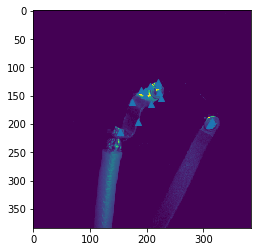

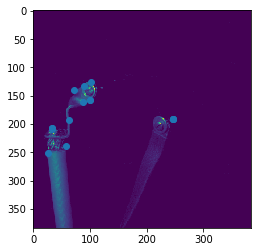

In [100]:
#pts1 = np.int32(pts1)
#pts2 = np.int32(pts2)
pts1 = np.asarray(pts1)
pts2 = np.asarray(pts2)

F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
N=50
t = np.arange(100)
# We select only inlier points
#pts1 = pts1[mask.ravel()==1]
#pts2 = pts2[mask.ravel()==1]
print(pts2)
print(pts1)
plt.figure()
plt.imshow(img1)
plt.scatter(pts1[:,0],pts1[:,1], marker='^',cmap=t)
plt.show()
plt.imshow(img2)
plt.scatter(pts2[:,0],pts2[:,1], marker='o',cmap=t)
plt.show()

[[  99.43746948  157.84837341]
 [  99.43746948  157.84837341]
 [  57.36953354  238.36367798]
 [ 245.78965759  191.082901  ]
 [  89.92938995  133.66877747]
 [  71.9757843   139.87799072]
 [  25.05525208  252.19262695]
 [ 100.87359619  126.8221817 ]
 [  62.00101471  193.2830658 ]
 [  33.20332718  206.47157288]
 [  32.53753281  209.86569214]
 [  33.20332718  206.47157288]
 [ 245.78965759  191.082901  ]
 [ 245.78965759  191.082901  ]
 [  87.56652832  161.81176758]
 [ 245.78965759  191.082901  ]]
[[  9.11505282e-01   4.11288351e-01  -2.36811783e+02]
 [  9.11505282e-01   4.11288351e-01  -2.36811783e+02]
 [  9.87176299e-01  -1.59633934e-01  -1.72775833e+02]
 [  9.99756396e-01  -2.20715031e-02  -1.94287247e+02]
 [  3.13762128e-01   9.49501634e-01  -1.93272324e+02]
 [ -2.49578550e-01   9.68354583e-01  -8.46832504e+01]
 [  9.25858617e-01  -3.77870053e-01  -1.30485031e+02]
 [  4.87868279e-01   8.72917235e-01  -2.17045349e+02]
 [  9.56229746e-01   2.92617023e-01  -2.29224716e+02]
 [  2.89278924e-0

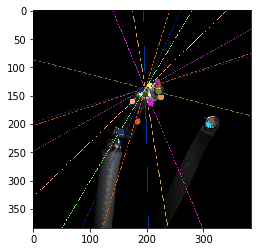

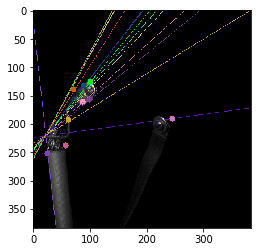

In [114]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        #print(r)
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])     
        cv2.line(img1, (x0,y0), (x1,y1), color,1)
        cv2.circle(img1,tuple(pt1),5,color,-1)
        cv2.circle(img2,tuple(pt2),5,color,-1)
        #plt.imshow(img1)
        #plt.show()
        #plt.imshow(img2)
        #plt.show()
    return img1,img2

lines1 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2).astype('float32'), 2,F)
lines1 = lines1.reshape(-1,3)
print(pts1)
print(lines1)
img5,img6 = drawlines(img1,img2,lines1,pts1.astype('int32'),pts2.astype('int32'))

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2).astype('float32'), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2.astype('int32'),pts1.astype('int32'))


plt.imshow(img5)
plt.show()
plt.imshow(img3)
plt.show()